# SetFit for Multilabel Text Classification

notebook based on https://github.com/huggingface/setfit/blob/main/notebooks/text-classification_multilabel.ipynb

See also:

- https://huggingface.co/docs/setfit/en/how_to/multilabel
- https://github.com/huggingface/setfit/issues/413#issuecomment-1697751329

## Setup

In [1]:
import numpy as np
import pandas as pd
import torch

import datasets
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer
from setfit import SetFitHead, SetFitModel
from utils.setfit import SetFitHeadWithClassWeights, get_class_weights

from setfit import TrainingArguments, Trainer
from sentence_transformers.losses import CosineSimilarityLoss

from utils.metrics import *
import matplotlib.pyplot as plt

/Users/hlicht/miniforge3/envs/galtan_group_appeals/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Mapping, Optional, Union
from numpy._typing import NDArray

get_device = lambda: 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

def model_init(
        model_name: str,
        id2label: Mapping[int, str], 
        multitarget_strategy: Optional[str]=None, 
        class_weights: Optional[NDArray]=None,
        device: Optional[Union[str, torch.device]]=None
    ) -> "SetFitModel":
    if class_weights is not None:
        assert len(id2label) == len(class_weights), 'len(id2label) must equal len(class_weights)'
    
    if device is None:
        device = get_device()
    
    body = SentenceTransformer(model_name, device='cpu')
    
    head_kwargs = dict(
        in_features=body.get_sentence_embedding_dimension(), 
        out_features=len(id2label),
        device='cpu',
        multitarget=isinstance(multitarget_strategy, str),
    )
    if class_weights is None:
        head = SetFitHead(**head_kwargs)
    else:
        head_kwargs['class_weights'] = class_weights
        head = SetFitHeadWithClassWeights(**head_kwargs)
    
    return SetFitModel(
        model_head=head,
        model_body=body,
        multitarget_strategy=multitarget_strategy,
        labels=list(id2label.values()),
        id2label=id2label
    ).to(device)

In [3]:
MODEL = "sentence-transformers/paraphrase-mpnet-base-v2"

In [4]:
# TODO:
#  - prepare dataset function
#  - prepare model function

## Preparing the dataset

In [5]:
import os 
data_path = '../../data/annotations/group_mention_categorization/social-group-mention-categorization-coder-training'
fp = os.path.join(data_path, 'parsed', 'consolidated_annotations.tsv')

df_all = pd.read_csv(fp, sep='\t')
df_all.q_id.unique()

array(['economic_attributes', 'non-economic_attributes', 'stance',
       'universal_attributes'], dtype=object)

## Universal attributes

In [6]:
# NOTE: let's focus on non-economic attributes for now
df = df_all.loc[df_all.q_id == 'universal_attributes', ['text', 'mention', 'label']]

In [7]:
df[['label']].value_counts(sort=False)
# NOTE: extreme label class imbalance 

label
No       244
Yes       56
Name: count, dtype: int64

In [8]:
label2id = {'No': 0, 'Yes': 1}
id2label = {0: 'No', 1: 'Yes'}

In [9]:
df.label = df.label.map(label2id)

### split the data

In [10]:
# TODO: consider increasing train size
trn, tst = train_test_split(range(len(df)), test_size=0.5, stratify=df.label, random_state=42)

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [12]:
df['input'] = df.text + tokenizer.sep_token + df.mention

In [13]:
cols = ['input', 'label']
dataset = datasets.DatasetDict({
    'train': datasets.Dataset.from_pandas(df.iloc[trn][cols], preserve_index=False),
    'test': datasets.Dataset.from_pandas(df.iloc[tst][cols], preserve_index=False)
})

### fine-tune

In [14]:
args = TrainingArguments(
    output_dir='setfit',
    batch_size=(32, 4),
    num_epochs=(1, 1),
    max_steps=10,
    body_learning_rate=(2e-5, 1e-5),
    head_learning_rate=1e-2,
    end_to_end=True,
    samples_per_label=2, # default but can be increased for TripletLoss
    loss=CosineSimilarityLoss, # note: could use TripletLoss
    use_amp=True,
    report_to='none'
)

In [15]:
class_weights = get_class_weights(np.array(dataset['train']['label']))
dict(zip(id2label.values(), class_weights))

{'No': 0.18666666666666668, 'Yes': 0.8133333333333334}

In [ ]:
trainer = Trainer(
    model_init=lambda: model_init(
        model_name=MODEL,
        id2label=id2label,
        # class_weights=class_weights,
        device='mps'
    ),
    args=args,
    metric=compute_metrics_binary,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    column_mapping={'input': 'text', 'label': 'label'},
)

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Map: 100%|██████████| 150/150 [00:00<00:00, 23172.10 examples/s]


: 

In [ ]:
trainer.train()

***** Running training *****
  Num unique pairs = 320
  Batch size = 32
  Num epochs = 1
 10%|█         | 1/10 [00:01<00:16,  1.80s/it]

{'embedding_loss': 0.3198, 'grad_norm': 1.4696723222732544, 'learning_rate': 2e-05, 'epoch': 0.1}


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]
The `max_length` is `None`. Using the maximum acceptable length according to the current model body: 512.


{'train_runtime': 14.9643, 'train_samples_per_second': 21.384, 'train_steps_per_second': 0.668, 'train_loss': 0.2629508078098297, 'epoch': 1.0}


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

In [1]:
import transformers
transformers.__version__

/Users/hlicht/miniforge3/envs/galtan_group_appeals/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'4.45.2'

### evaluate

In [ ]:
y_true = np.array(dataset['test']['label'])
y_pred = trainer.model.predict(dataset['test']['input'], use_labels=False).cpu().numpy()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=id2label.values()))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       122
           1       0.71      0.43      0.53        28

    accuracy                           0.86       150
   macro avg       0.79      0.69      0.73       150
weighted avg       0.85      0.86      0.85       150



In [66]:
# inputs = trainer.model.model_body.tokenizer(dataset['test']['input'][:16], return_tensors='pt', padding=True)
# with torch.no_grad():
#     embeddings = trainer.model.model_body(inputs.to('mps'))
#     # outputs = trainer.model.model_head.linear(embeddings['sentence_embedding']).cpu().numpy()
#     logits, probs = trainer.model.model_head(embeddings['sentence_embedding'], temperature=1.0)
#     logits = logits.cpu().numpy()
#     probs = probs.cpu().numpy()

# probs.round(3) # overconfidence, need to apply early stopping?

In [21]:
probs = trainer.model.predict_proba(dataset['test']['input'], as_numpy=True)
probs.round(3)

array([[1.   , 0.   ],
       [1.   , 0.   ],
       [0.99 , 0.01 ],
       [0.005, 0.995],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.999, 0.001],
       [0.962, 0.038],
       [1.   , 0.   ],
       [0.001, 0.999],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.997, 0.003],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.008, 0.992],
       [1. 

/var/folders/_c/cm0nk6y92rz2l6ct3npgw9tr0000gn/T/ipykernel_53423/4132908749.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pred_probs[labs==0], pred_probs[labs==1]], labels=['No', 'Yes'])


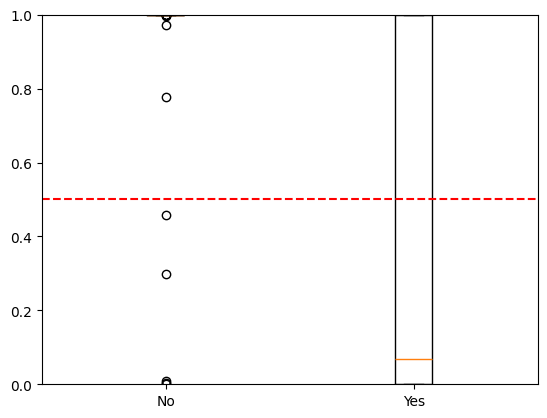

In [22]:
labs = np.array(dataset['test']['label'])
pred_probs = probs[range(len(labs)), labs]

# plot boxplot of predicted probabilities by true label
plt.boxplot([pred_probs[labs==0], pred_probs[labs==1]], labels=['No', 'Yes'])
plt.ylim(0, 1)
# draw a line at 0.5
plt.axhline(0.5, color='r', linestyle='--')
plt.show()

## Universal/econ/non-econ as three-way multilabel problem

In [24]:
df = pd.read_csv(fp, sep='\t')
df.columns

Index(['mention_id', 'text', 'mention', 'prev_texts', 'next_texts', 'q_id',
       'q_category', 'category', 'label', 'source'],
      dtype='object')

In [25]:
# stack by category
tmp = pd.concat([
    df[df.q_id == 'universal_attributes'].drop(columns=['category']),
    df[df.q_id == 'economic_attributes'].groupby(['mention_id', 'text', 'mention', 'q_id']).agg({'label': lambda x: 'Yes' if (x=='Yes').any() else 'No'}).reset_index(),
    df[df.q_id == 'non-economic_attributes'].groupby(['mention_id', 'text', 'mention', 'q_id']).agg({'label': lambda x: 'Yes' if (x=='Yes').any() else 'No'}).reset_index()
])
tmp.reset_index(drop=True, inplace=True)

# get dimensions
tmp.q_id = tmp.q_id.str.removesuffix('_attributes')
features = tmp.q_id.unique().tolist()

# reshape to wide format
tmp = tmp.pivot(index=['mention_id', 'text', 'mention'], columns='q_id', values='label').reset_index()
tmp = tmp.rename_axis(None, axis=1)

# keep only fully gold-labeled examples
tmp = tmp[tmp[features].isna().sum(axis=1) == 0]

In [27]:
tmp[features].value_counts(dropna=False)

universal  economic  non-economic
No         No        Yes             130
           Yes       No               98
Yes        No        No               38
                     Yes              17
No         Yes       Yes              15
           No        No                1
Yes        Yes       No                1
Name: count, dtype: int64

In [28]:
label2id = {'No': 0, 'Yes': 1}
id2label = {0: 'No', 1: 'Yes'}
tmp.loc[:,features] = tmp.loc[:,features].apply(lambda x: x.map(label2id))

In [29]:
tmp['labels'] = tmp.loc[:,features].apply(list, axis=1)

In [30]:
tmp[features].mean(axis=0)
# strong label class imbalance

universal       0.186667
economic            0.38
non-economic        0.54
dtype: object

## split the data

In [31]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [32]:
tmp['input'] = tmp.text + tokenizer.sep_token + tmp.mention 

In [33]:
max_length_ = max(tokenizer(tmp.input.to_list(), truncation=False, padding=False, return_length=True).length)

In [34]:
trn, tst = train_test_split(range(len(tmp)), test_size=0.5, random_state=42)

In [35]:
cols = ['input', 'labels']
dataset = datasets.DatasetDict({
    'train': datasets.Dataset.from_pandas(tmp.iloc[trn][cols], preserve_index=False),
    'test': datasets.Dataset.from_pandas(tmp.iloc[tst][cols], preserve_index=False)
})

In [37]:
feats = tmp.iloc[tst][features].to_numpy()
class_weights = get_class_weights(feats, multitarget=True)
class_weights = class_weights.astype(float)
class_weights

array([0.53439587, 0.27188562, 0.1937185 ])

## Fine-tuning the model

In [39]:
id2label = {i: l for i, l in enumerate(features)}
label2id = {l: i for i, l in enumerate(features)}
id2label

{0: 'universal', 1: 'economic', 2: 'non-economic'}

In [51]:
# import torch
# from setfit import SetFitModel
# 
# device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# def model_init():
#     return SetFitModel.from_pretrained(
#         model_name, 
#         use_differentiable_head=True, 
#         head_params={"out_features": len(features)},
#         multi_target_strategy='one-vs-rest',
#         labels=features,
#         id2label=id2label
#     ).to(device)

In [40]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir='setfit',
    batch_size=(32, 4),
    max_length=max_length_,
    num_epochs=(1, 8),
    max_steps=100,
    end_to_end=False,
    samples_per_label=2,
    loss=CosineSimilarityLoss,
    use_amp=True,
    report_to='none'
)

In [42]:
from utils.metrics import compute_metrics_multilabel
trainer = Trainer(
    model_init=lambda: model_init(
        model_name=MODEL,
        id2label=id2label,
        multitarget_strategy='one-vs-rest',
        class_weights=class_weights,
        device='mps'
    ),
    metric=lambda p, t: compute_metrics_multilabel(p, t, id2label),
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    column_mapping={"input": "text", "labels": "label"},
)

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Map: 100%|██████████| 150/150 [00:00<00:00, 22468.68 examples/s]


In [43]:
trainer.train()

***** Running training *****
  Num unique pairs = 3200
  Batch size = 32


  Num epochs = 1
  1%|          | 1/100 [00:01<02:19,  1.41s/it]

{'embedding_loss': 0.2914, 'grad_norm': 1.404127836227417, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}


 50%|█████     | 50/100 [01:16<01:24,  1.70s/it]

{'embedding_loss': 0.232, 'grad_norm': 1.1662814617156982, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}


100%|██████████| 100/100 [02:38<00:00,  1.74s/it]

{'embedding_loss': 0.1633, 'grad_norm': 0.6780321002006531, 'learning_rate': 0.0, 'epoch': 1.0}


100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


{'train_runtime': 162.6298, 'train_samples_per_second': 19.677, 'train_steps_per_second': 0.615, 'train_loss': 0.19825524896383284, 'epoch': 1.0}


Epoch: 100%|██████████| 8/8 [00:27<00:00,  3.47s/it]


In [44]:
metrics = trainer.evaluate()

***** Running evaluation *****


In [45]:
res = pd.DataFrame(metrics, index=[0]).T.reset_index().rename(columns={'index': 'metric', 0: 'value'})
res[['metric', 'category']] = res.metric.str.split('_', expand=True)
res = res.pivot(index='category', columns='metric', values='value')
# remove index names
res.columns.name = None
res.index.name = None
res.loc[['macro']+features]

,f1,precision,recall,support
macro,0.700008,0.813050,0.633071,NaN
universal,0.465116,0.714286,0.344828,29.0
economic,0.803738,0.860000,0.754386,57.0
non-economic,0.831169,0.864865,0.800000,80.0


In [46]:
probs = trainer.model.predict_proba(dataset['test']['input'], as_numpy=True)

array([1.262, 0.462, 0.276, 0.448, 0.038, 1.179, 0.035, 0.305, 1.273,
       1.947, 0.655, 0.022, 1.043, 0.369, 0.807, 1.141, 0.995, 0.27 ,
       1.823, 0.016, 0.009, 0.878, 0.483, 1.281, 0.347, 0.023, 0.952,
       0.098, 1.019, 0.111, 1.176, 0.02 , 0.339, 1.578, 0.289, 0.848,
       0.495, 0.527, 0.068, 1.899, 0.03 , 0.045, 1.782, 0.059, 1.352,
       1.088, 1.074, 0.421, 0.029, 0.383, 0.403, 0.24 , 0.037, 0.167,
       0.139, 1.461, 1.759, 0.009, 0.798, 0.958, 0.398, 0.04 , 0.147,
       1.166, 0.884, 0.032, 1.205, 0.009, 1.758, 0.016, 0.541, 0.004,
       0.272, 0.461, 1.896, 0.016, 0.007, 0.045, 0.053, 0.109, 0.101,
       0.23 , 0.024, 0.083, 0.925, 0.982, 0.809, 1.557, 0.747, 0.071,
       0.134, 1.19 , 0.047, 0.028, 0.068, 0.285, 0.421, 0.022, 1.462,
       0.125, 0.968, 0.02 , 0.478, 0.458, 0.152, 0.053, 0.041, 0.013,
       0.23 , 0.118, 0.872, 0.077, 0.5  , 0.679, 0.342, 1.739, 0.065,
       0.018, 0.95 , 0.988, 0.695, 0.561, 1.008, 1.867, 0.884, 0.357,
       0.232, 0.006,

In [61]:
probs_df = pd.DataFrame(probs, columns=['pred: '+f for f in features]).round(3)
# compute loss 
losses = np.array(dataset['test']['labels']) - probs
probs_df['loss'] = np.abs(losses).sum(axis=1).round(3)
probs_df[features] = tmp.iloc[tst, :][features].reset_index(drop=True)
probs_df[['text', 'mention']] = pd.Series(dataset['test']['input']).str.split(tokenizer.sep_token, expand=True)
probs_df.sort_values('loss', ascending=False).head(20)

,pred: universal,pred: economic,pred: non-economic,loss,universal,economic,non-economic,text,mention
9,0.001,0.985,0.039,1.947,0,0,1,The Greens demand that the multinationals base...,the multinationals based in Switzerland
39,0.010,0.930,0.041,1.899,0,0,1,The separation on the joint energy companies o...,the nationals
74,0.092,0.986,0.002,1.896,1,0,0,The creation of conditions for supporting the ...,consumers
123,0.000,0.053,0.919,1.867,0,1,0,Improve the compatibility of work and family t...,daymothers
18,0.018,0.013,0.828,1.823,1,0,0,That is why the government of the center is co...,all layers of the population
42,0.015,0.792,0.006,1.782,1,0,0,This SNS program statement does not close itse...,the individual
56,0.002,0.920,0.164,1.759,0,0,1,The problem of foreigners in Flanders is prima...,the host workers
68,0.057,0.004,0.811,1.758,1,0,0,Every person belongs to a minority.,a minority
115,0.588,0.084,0.236,1.739,0,1,0,Or go toward an ecological society where the e...,an ecological society
33,0.001,0.262,0.839,1.578,0,1,0,Limit the waiting time to specialist care to a...,full-time and part-time health care professionals


In [30]:
# IDEA: measure uncertainty by computing closeness to classification threshold
threshold = np.ones(probs.shape)/2
cuts = probs - threshold
vals = np.abs(cuts).min(axis=1)
idxs = vals.argsort()[::1]

probs_df.iloc[idxs, :].head(16)#.text.to_list()
# TODO: compute share of misclassification as indicator of informativeness of ranking criterion

,universal_pred,economic_pred,non-economic_pred,universal,economic,non-economic,text,mention
31,0.000,0.510,0.698,0,0,1,This is what today’s pensioners and the workin...,the working generation
28,0.000,0.896,0.526,0,1,0,Allocate a special annual budget of 500 billio...,military personnel
52,0.001,0.180,0.451,0,1,0,Labour will end the scandal of leasehold for t...,the millions who have bought their home but do...
30,0.217,0.429,0.002,0,0,1,The RPS has shown that it is the only politica...,the mafia
63,0.006,0.079,0.389,1,0,0,"Women at work, whether wives and mothers or th...",the community
27,0.688,0.626,0.000,1,0,0,The potential of the digital information socie...,the digital information society
49,0.003,0.649,0.023,0,1,0,We will ensure that our farmers also have an a...,our farmers
58,0.665,0.189,0.001,1,0,0,x Businesses should pay a normal share of thei...,society
35,0.000,0.326,0.978,0,0,1,Women and people with migrant backgrounds are ...,people with migrant backgrounds
75,0.005,0.029,0.694,0,0,1,"Women have a better education, more financial ...",Women


In [42]:
# inference

text_data_file = '../../data/intermediate/social_group_mentions_ranked.tsv'
texts = pd.read_csv(text_data_file, sep='\t', nrows=32*200) # has 13748 rows

probs = trainer.model.predict_proba(texts.text.to_list(), as_numpy=True, show_progress_bar=True)

Batches: 100%|██████████| 145/145 [00:14<00:00, 10.00it/s]


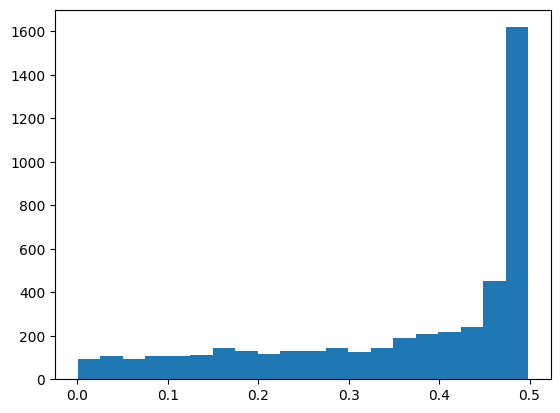

In [43]:
threshold = np.ones(probs.shape)/2
cuts = probs - threshold
vals = np.abs(cuts).min(axis=1)
# plot histogram of vals
plt.hist(vals, bins=20)
plt.show()
# NOTE: shows overall high "confidence" (maybe overconfidence)

In [49]:
n_ = 100
idxs = vals.argsort()[:n_]

pd.concat([
    texts.iloc[idxs, :][['text', 'mention']].reset_index(drop=True),
    pd.DataFrame(probs[idxs, :].round(3), columns=features),

], axis=1 )

,text,mention,universal,economic,non-economic
0,Maintaining America's pre-eminence requires a ...,all students,0.500,0.002,0.196
1,All owners of immovable assets on the territor...,All owners of immovable assets on the territor...,0.008,0.500,0.585
2,"In a powerful welfare community, basic service...",a powerful welfare community,0.097,0.004,0.501
3,We will take advantage of the opportunities of...,workers,0.501,0.217,0.001
4,"In the knowledge society, universities must be...",the knowledge society,0.362,0.498,0.007
...,...,...,...,...,...
95,Public transportation will be free for the une...,the unemployed,0.004,0.471,0.475
96,More Americans are working now than at any tim...,Americans,0.475,0.085,0.037
97,These are or individuals who are trying to avo...,individuals who are trying to avoid taxation,0.000,0.526,0.692
98,A society in which it is good to be a child is...,everyone,0.474,0.000,0.590


## Non-econ attributes

In [3]:
# NOTE: let's focus on non-economic attributes for now
df = pd.read_csv(fp, sep='\t')
df = df[df.q_id == 'non-economic_attributes']
df = df[~df.category.isna()]

In [ ]:
df[['category', 'label']].value_counts(sort=False)
# NOTE: extreme label class imbalance 

In [ ]:
keep_cats = df[df.label == 'Yes'].category.unique().tolist()

df = df[df.category.isin(keep_cats)]
df[['category', 'label']].value_counts(sort=False)


In [ ]:
# remove any instances where some are Unsure
discard = df.groupby('mention_id').agg({'label': lambda l: (l == 'Unsure').any()})
discard = discard[discard.label].index.to_list()

df = df[~df.mention_id.isin(discard)]

df[['category', 'label']].value_counts(sort=False)


In [ ]:
df = df[['text', 'mention', 'category', 'label']]

# pivot wider
df = df.pivot(index=['text', 'mention'], columns='category', values='label').reset_index()

features = df.columns[2:].to_list()

features

In [8]:
df = df[df.iloc[:,3:].isna().sum(axis=1) == 0.0]

In [9]:
label2id = {'No': 0, 'Yes': 1}
id2label = {0: 'No', 1: 'Yes'}
df.loc[:,features] = df.loc[:,features].apply(lambda x: x.map(label2id))

In [10]:
df['labels'] = df.loc[:,features].apply(list, axis=1)

In [ ]:
df[features].mean(axis=0)
# still crazy label class imbalance

### split the data

In [ ]:
df[features].reset_index(drop=True)

In [13]:
# from skmultilearn.model_selection import IterativeStratification
# 
# X = np.zeros((len(df), 1))# df[['text', 'mention', 'labels']]
# y = df[features].reset_index(drop=True)
# test_size = 0.4
# stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
# stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
# train_indexes, test_indexes = next(stratifier.split(X, y))


In [14]:
from sklearn.model_selection import train_test_split

trn, tst = train_test_split(range(len(df)), test_size=0.5, random_state=42)

In [15]:
model_name = "sentence-transformers/paraphrase-mpnet-base-v2"
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [16]:
df['input'] = df.text + tokenizer.sep_token + df.mention 

In [17]:
cols = ['input', 'labels']
dataset = datasets.DatasetDict({
    'train': datasets.Dataset.from_pandas(df.iloc[trn][cols], preserve_index=False),
    'test': datasets.Dataset.from_pandas(df.iloc[tst][cols], preserve_index=False)
})

### Fine-tuning the model

In [18]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer(model_name, device='cpu')

To train a SetFit model, the first thing to do is download a pretrained checkpoint from the Hub. We can do so by using the `from_pretrained()` method associated with the `SetFitModel` class.

**Note that the `multi_target_strategy` parameter here signals to both the model and the trainer to expect a multi-labelled dataset.**

In [19]:
id2label = {i: l for i, l in enumerate(features)}
label2id = {l: i for i, l in enumerate(features)}

### Non-diff head (regression)

In [ ]:
from setfit import SetFitModel

model = SetFitModel.from_pretrained(
    model_name, 
    multi_target_strategy='one-vs-rest',
    labels=features
)

Alternative is to init explicitly (see [here](https://github.com/huggingface/setfit/issues/413#issuecomment-1697751329))

```python
from sentence_transformers import SentenceTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
embedder = SentenceTransformer('all-MiniLM-L6-v2')
model = SetFitModel(
    model_body=embedder, 
    model_head=OneVsRestClassifier(LogisticRegression(class_weight="balanced")),
    multi_target_strategy="one-vs-rest"
)
```

In [112]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
def model_init():
    return SetFitModel.from_pretrained(
        model_name, 
        use_differentiable_head=True, 
        head_params={"out_features": len(features)},
        multi_target_strategy='one-vs-rest',
        labels=features,
    ).to(device)

In [113]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir='setfit',
    batch_size=(16, 4),
    num_epochs=(2, 8),
    samples_per_label=2, # default but can be increased for TripletLoss
    loss=CosineSimilarityLoss, # note: could use TripletLoss
    use_amp=True,
    end_to_end=False,
    report_to='none'
)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    column_mapping={"input": "text", "labels": "label"},
)

In [ ]:
trainer.train()

The final step is to compute the model's performance using the `evaluate()` method. The default metric measures 'subset accuracy', which measures the fraction of samples where we predict all 8 labels correctly.

In [ ]:
metrics = trainer.evaluate()
metrics

In [117]:
y_true = np.array(dataset['test']["labels"])
y_pred = trainer.model.predict(dataset['test']["input"], use_labels=False).cpu().numpy()

In [99]:
# import torch
# inputs = tokenizer(['hello'], return_tensors='pt')
# 
# with torch.no_grad():
#     embeddings = trainer.model.model_body(inputs.to('mps'))
#     logits, probs = trainer.model.model_head(embeddings['sentence_embedding'], temperature=1.0)

In [ ]:
from collections import  Counter
Counter([id2label[i] for labs in dataset['train']["labels"] for i, l in enumerate(labs) if l == 1])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
scores = {}
for l, a, b in zip(trainer.model.labels, y_true.T, y_pred.T):
    p, r, f1, _ = precision_recall_fscore_support(a, b, average='binary', zero_division=0.0)
    scores[l] = {'f1': f1, 'precision': p, 'recall': r, 'support': np.sum(a)}
pd.DataFrame(scores).T

# {f'{m}_{l}': v for l, s in scores.items() for m, v in s.items()} 

In [151]:
inputs = trainer.model.model_body.tokenizer(dataset['test']['input'][:16], return_tensors='pt', padding=True)
with torch.no_grad():
    embeddings = trainer.model.model_body(inputs.to('mps'))
    outputs = trainer.model.model_head.linear(embeddings['sentence_embedding'])
    # logits, probs = trainer.model.model_head(embeddings['sentence_embedding'], temperature=1.0)
    # logits = logits.cpu().numpy()
    # probs = probs.cpu().numpy()

threshold = np.ones(probs.shape)/2
cuts = probs - threshold
idx = np.abs(cuts).mean(axis=1).argmin()

probs[idx], y_pred[idx], y_true[idx], dataset['test']['input'][idx]

In [ ]:
# IDEA: focus sentence embedding model on mention
inputs = embedder.tokenizer(dataset['test']['input'][:1], return_tensors='pt', padding=True)

import torch
with torch.no_grad():
    features = embedder[0](features=inputs)

token_embeddings = features["token_embeddings"]
attention_mask = (
    features["attention_mask"]
    if "attention_mask" in features
    else torch.ones(token_embeddings.shape[:-1], device=token_embeddings.device, dtype=torch.int64)
)

mask = features['input_ids'] == embedder.tokenizer.sep_token_id
mask = mask.cumsum(dim=1) == 1
# convert mask to same type as attention_mask
mask = mask.to(attention_mask.dtype)
attention_mask = mask

# note: this is what happens in the SentenceTransformer model under the hood
input_mask_expanded = (
    attention_mask.unsqueeze(-1).expand(token_embeddings.size()).to(token_embeddings.dtype)
)
sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)

sum_mask = input_mask_expanded.sum(1)

sum_mask = torch.clamp(sum_mask, min=1e-9)

output_vector = sum_embeddings / sum_mask

output_vector.shape

## Stance

In [50]:
# NOTE: let's focus on non-economic attributes for now
df = pd.read_csv(fp, sep='\t')
df = df[df.q_id == 'stance']

In [51]:
df[['label']].value_counts(sort=False)
# NOTE: extreme label class imbalance 

label   
Negative     24
Neutral      12
Positive    215
Name: count, dtype: int64

In [52]:
df = df[['text', 'mention', 'label']]

In [53]:
label2id = {'Neutral': 0, 'Positive': 1, 'Negative': 2}
id2label = {i: l for l, i in label2id.items()}

In [54]:
df.label = df.label.map(label2id)

### split the data

In [55]:
trn, tst = train_test_split(range(len(df)), test_size=0.5, stratify=df.label, random_state=42)

In [56]:
model_name = "sentence-transformers/paraphrase-mpnet-base-v2"
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [57]:
df['input'] = df.text + tokenizer.sep_token + df.mention

In [ ]:
max_length_ = max(tokenizer(df.input.to_list(), truncation=False, padding=False, return_length=True).length)

In [58]:
cols = ['input', 'label']
dataset = datasets.DatasetDict({
    'train': datasets.Dataset.from_pandas(df.iloc[trn][cols], preserve_index=False),
    'test': datasets.Dataset.from_pandas(df.iloc[tst][cols], preserve_index=False)
})

### Fine-tuning the model

In [66]:
args = TrainingArguments(
    output_dir='setfit',
    batch_size=(32, 4),
    max_length=max_length_,
    num_epochs=(1, 8),
    max_steps=10,
    body_learning_rate=(2e-5, 1e-5),
    head_learning_rate=1e-2,
    end_to_end=False,
    samples_per_label=2, # default but can be increased for TripletLoss
    loss=CosineSimilarityLoss, # note: could use TripletLoss
    use_amp=True,
    report_to='none'
)

In [67]:
class_weights = get_class_weights(np.array(dataset['train']['label']))
dict(zip(id2label.values(), class_weights))

{'Neutral': 0.6426426426426426,
 'Positive': 0.036036036036036036,
 'Negative': 0.3213213213213213}

In [70]:
trainer = Trainer(
    model_init=lambda: model_init(
        model_name=MODEL,
        id2label=id2label,
        class_weights=class_weights,
        device='mps'
    ),
    args=args,
    metric=lambda p, t: compute_metrics_multiclass(p, t, id2label),
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    column_mapping={'input': 'text', 'label': 'label'},
)

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Map: 100%|██████████| 125/125 [00:00<00:00, 23548.69 examples/s]


In [71]:
trainer.train()

***** Running training *****
  Num unique pairs = 320
  Batch size = 32
  Num epochs = 1
 10%|█         | 1/10 [00:03<00:27,  3.01s/it]

{'embedding_loss': 0.2235, 'grad_norm': 2.9313435554504395, 'learning_rate': 2e-05, 'epoch': 0.1}


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]
The `max_length` is `None`. Using the maximum acceptable length according to the current model body: 512.


{'train_runtime': 20.4446, 'train_samples_per_second': 15.652, 'train_steps_per_second': 0.489, 'train_loss': 0.2251264199614525, 'epoch': 1.0}


Epoch: 100%|██████████| 8/8 [01:17<00:00,  9.72s/it]


In [74]:
metrics = trainer.evaluate()
metrics

***** Running evaluation *****
/Users/hlicht/miniforge3/envs/galtan_group_appeals/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.873015873015873,
 'balanced_accuracy': 0.48765432098765427,
 'f1_macro': 0.4848248521479171,
 'precision_macro': 0.4832674571805007,
 'recall_macro': 0.48765432098765427,
 'precision_Neutral': 0.0,
 'recall_Neutral': 0.0,
 'f1_Neutral': 0.0,
 'precision_Positive': 0.9043478260869565,
 'recall_Positive': 0.9629629629629629,
 'f1_Positive': 0.9327354260089686,
 'precision_Negative': 0.5454545454545454,
 'recall_Negative': 0.5,
 'f1_Negative': 0.5217391304347826}

In [ ]:
inputs = trainer.model.model_body.tokenizer(dataset['test']['input'][:16], return_tensors='pt', padding=True)
with torch.no_grad():
    embeddings = trainer.model.model_body(inputs.to('mps'))
    # outputs = trainer.model.model_head.linear(embeddings['sentence_embedding']).cpu().numpy()
    logits, probs = trainer.model.model_head(embeddings['sentence_embedding'], temperature=1.0)
    logits = logits.cpu().numpy()
    probs = probs.cpu().numpy()

,Neutral,Positive,Negative
0,0.002,0.997,0.000
1,0.013,0.985,0.002
2,0.063,0.923,0.014
3,0.004,0.996,0.001
4,0.001,0.999,0.000
...,...,...,...
121,0.024,0.953,0.022
122,0.003,0.996,0.000
123,0.104,0.894,0.002
124,0.002,0.973,0.025


/var/folders/_c/cm0nk6y92rz2l6ct3npgw9tr0000gn/T/ipykernel_3273/3265651594.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


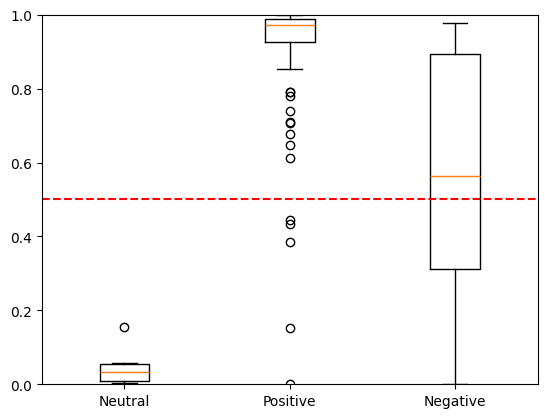

In [78]:
probs = trainer.model.predict_proba(dataset['test']['input'], as_numpy=True)
labs = np.array(dataset['test']['label'])
pred_probs = probs[range(len(labs)), labs]

# plot boxplot of predicted probabilities by true label
plt.boxplot(
    [pred_probs[labs==i] for i in id2label.keys()],
    labels=id2label.values()
)
plt.ylim(0, 1)
# draw a line at 0.5
plt.axhline(0.5, color='r', linestyle='--')
plt.show()